In [16]:
import xarray as xr
import numpy as np
import dask
import matplotlib.pyplot as plt
import os
import seaborn as sns
import pandas as pd
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
from functions import find_slopeloc

In [17]:
plt.rcParams.update({
    "text.usetex": False,
#    "font.family": "Helvetica"
})

In [19]:
rho = 1e3

In [20]:
case = "BLOM_channel_new05_mix1"
#case = "BLOM_channel_new02_mix1"

datapath = f"/nird/home/annals/BLOM-channel-momentum/data/{case}/"

ds_flux = xr.open_mfdataset(datapath+f"from_flux/{case}_from_flux_momentumterms_*.nc").mean("time")
ds_vel = xr.open_mfdataset(datapath+f"from_vel/{case}_from_vel_momentumterms_*.nc").mean("time")

figurepath = f"/nird/home/annals/BLOM-channel-momentum/figures/"

#ds = xr.open_mfdataset(datapath+f"{case}_momentumterms_*.nc")#.isel(y=slice(1,-1))
bath = xr.open_dataarray(datapath+f"{case}_bathymetry.nc")#.isel(y=slice(1,-1))

In [21]:
ds_vel["h"] = bath.mean(dim="x")

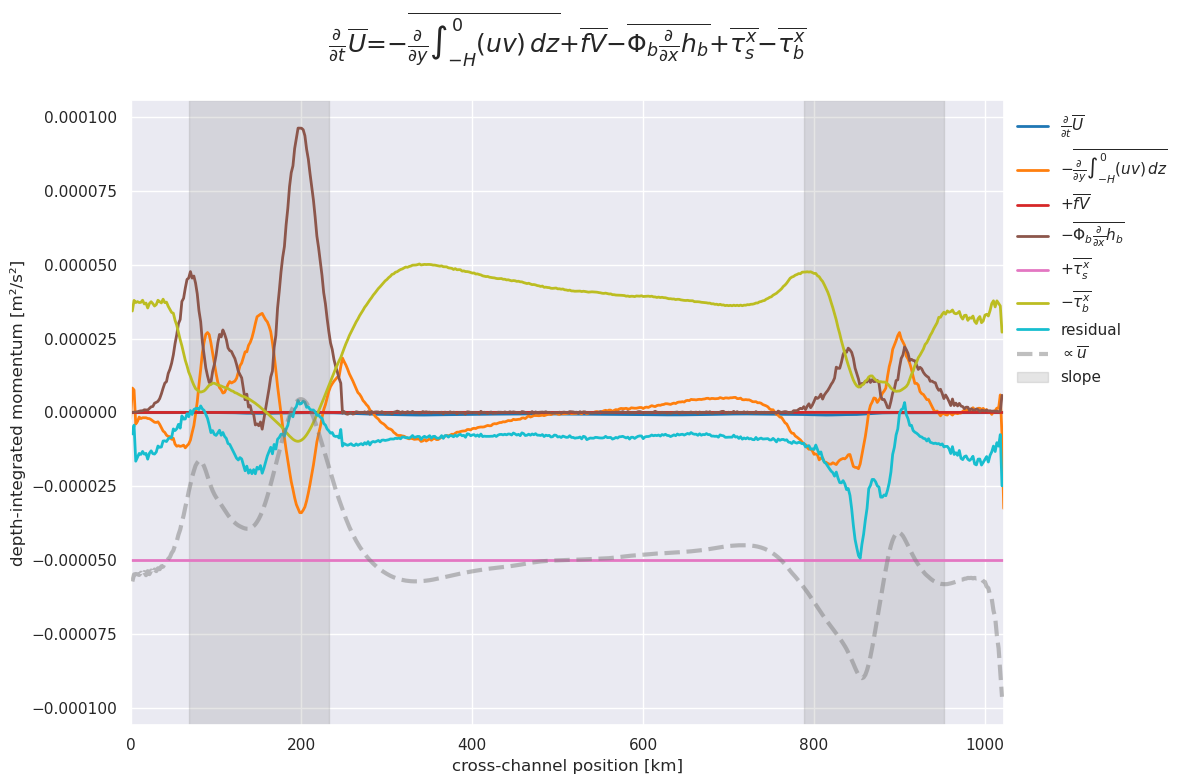

In [28]:
sns.set_theme()
fig, ax = plt.subplots(figsize=(12,8))
y = ds_vel.y/1e3
surface_forcing = [-0.05/rho]*len(y.values) 
MFD = -ds_vel.dUVdy
TFS = -ds_vel.phidhdx
dUdt = ds_flux.dUdt2
fV = ds_flux.fV1
bottom_drag = -ds_flux.tauxb1
res = -dUdt+MFD+TFS+fV+bottom_drag+surface_forcing


#ds_mean["residual"] = res




"""
ax2 = ax.twinx()
ax2.plot(y, bath_mean, alpha=0.2, color="gray", ls="--", zorder=100)
#ax2.set_ylabel("Depth [m]")
ax2.set_yticks([])
"""

ax.axhline(0, color="gray")

vars = [dUdt, MFD, fV, TFS, surface_forcing, bottom_drag, res]
labels = [r"$\frac{\partial}{\partial t}\overline{U}$", 
          r"$-\overline{\frac{\partial}{\partial y}\int_{-H}^0(uv)\,dz}$", 
          r"$+\overline{fV}$",
          r"$-\overline{\Phi_b\frac{\partial}{\partial x}h_b}$",
          r"$+\overline{\tau^x_s}$",
          r"$-\overline{\tau^x_b}$",
          "residual"
          ]

colors = mpl.colormaps['tab10'].resampled(len(vars)).colors

maxx = 0
for var, label, color in zip(vars, labels, colors):
    ax.plot(y, var, 
            label=label, 
            lw = 2,
            color=color
            )
    maxx = np.max([maxx, np.abs(var).max()])
    
scale = maxx/np.max(np.abs(ds_vel.ubar))
ax.plot(y, ds_vel.ubar*scale, 
         color="gray", 
         alpha=0.5,
         lw = 3,
         ls="--", 
         zorder=100,
         label=r"$\propto\overline{u}$"
         )    


lx0, lx1, rx0, rx1 = find_slopeloc(ds_vel.h, epsilon=0.01)
ax.axvspan(lx0/1e3, lx1/1e3, alpha=0.2, color="gray", label="slope")
ax.axvspan(rx0/1e3, rx1/1e3, alpha=0.2, color="gray")

ax.legend(loc='upper left', bbox_to_anchor=(1, 1), frameon=False)
ax.set_ylabel("depth-integrated momentum [m²/s²]")
ax.set_xlabel("cross-channel position [km]")
ax.set_xlim(np.min(y), np.max(y))

#eq = r"$\frac{\partial}{\partial t}\overline{U} = - \overline{\frac{\partial}{\partial y}\int_{-H}^0(uv)\,dz} -\overline{\Phi_b\frac{\partial}{\partial x}h_b} + \overline{\tau^x_s}-\overline{\tau^x_b}$"
eq = labels[0]+"="
for term in labels[1:-1]:
    eq+=term
ax.set_title(eq+"\n", fontsize=18)

plt.tight_layout()
fig.savefig(figurepath+f"{case}_momentumTerms.png")